In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import os.path
from tqdm import tqdm
import pathlib
import imodelsx.llm
import json
import requests
import numpy as np
import openai
import pubmed
import prompts
openai.api_key = open('/home/chansingh/.OPENAI_KEY').read().strip()
plt.style.use('default')
dvu.set_style()

df = pd.read_csv('../data/main.csv')
df = df[df['id'].notna()]

# extract text from pdfs
ids_with_paper = df[
    (df["found_paper (0=no, 1=yes)"] == 1)
    | (df["found_paper (0=no, 1=yes)"] == 2)
].id

# d = pd.read_csv('../data/mini.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/111 [00:00<?, ?it/s]

100%|██████████| 111/111 [00:03<00:00, 28.42it/s]


### Ask questions about the text

In [ ]:
pubmed.extract_texts_from_pdf(ids_with_paper)

# llm = imodelsx.llm.get_llm("gpt-3.5-turbo-0613")
llm = imodelsx.llm.get_llm("gpt-4-0613")
# llm = imodelsx.llm.get_llm("gpt-4-32k-0613")

# properties, functions, content_str = prompts.get_prompts_demographics()
properties, functions, content_str = prompts.get_prompts_gender()
messages = [
    {
        "role": "user",
        "content": content_str,
    }
]

# example with answer: One hundred and five patients, 55 males and 50 females
toy_input1 = """This study was about treating diabetes. It was a very difficult study.
One hundred and five patients, 55 males and 50 females were included.
The study took 200 days to complete. The study was conducted in the United States.
The study was conducted by the University of California, San Francisco."""

# example with answer: One hundred and five patients, 55 males and 50 females, 10 white, 75 black
toy_input2 = """This study was about treating diabetes. It was a very difficult study.
One hundred and five patients, 55 males and 50 females were included.
The study took 200 days to complete. The study was conducted in the United States.
Ten of the patients were white, 20 were asian, and the rest were black.
The study was conducted by the University of California, San Francisco."""

# messages[0]['content'] = content_str.format(input=toy_input1)
# msg = llm(messages, functions=functions, return_str=False, temperature=0.0)
# args = json.loads(msg.get('function_call')['arguments'])
# print(json.dumps(args, indent=2))

# messages[0]['content'] = content_str.format(input=toy_input2)
# msg = llm(messages, functions=functions, return_str=False, temperature=0.0)
# args = json.loads(msg.get('function_call')['arguments'])
# print(json.dumps(args, indent=2))

In [ ]:
def rename_to_none(x: str):
    if x in {"", "unknown", "N/A"}:
        return None
    else:
        return x


def call_on_subsets(x: str, subset_len_tokens=4750, max_calls=3):
    subset_len_chars = subset_len_tokens * 4

    args = None
    subset_num = 0

    while args is None and subset_num < max_calls:
        subset = x[subset_num * subset_len_chars : (subset_num + 1) * subset_len_chars]

        # if approx_tokens < 6000:
        messages[0]["content"] = content_str.format(input=subset)
        msg = llm(messages, functions=functions, return_str=False, temperature=0.0)
        if msg is not None and msg.get("function_call") is not None:
            args = json.loads(msg.get("function_call")["arguments"])
            return args

        subset_num += 1

        # next segment should have atleast 0.5 * subset_len_chars_left
        if len(x) < (subset_num + 0.5) * subset_len_chars:
            break

    return None


def check_evidence(ev: str, real_input: str):
    if ev is not None:
        # remove all whitespace
        ev = "".join(ev.split())
        real_input = "".join(real_input.split())
        return ev.lower() in real_input.lower()
    return False


# initialize
for k in properties.keys():
    df.loc[:, k] = None
# df["approx_tokens"] = None

# run loop
for id in tqdm(ids_with_paper):
    i = df[df.id == id].index[0]
    row = df.iloc[i]
    paper_file = join("../papers", str(int(row.id)) + ".txt")

    try:
        real_input = pathlib.Path(paper_file).read_text()
        # gpt4 has 8k token window (some of it is functions, etc.)
        # approx_tokens = (len(real_input) / 4)
        # df.loc[i, "approx_tokens"] = approx_tokens
        args = call_on_subsets(real_input)

        # print(json.dumps(args, indent=2))
        if args is not None:
            for k in properties.keys():
                if k in args:
                    # set the value at row number i and column k to the value of args[k]
                    df.loc[i, k] = rename_to_none(args[k])

                    # remove spans if they are not actually contained in the text
                    if k in ["num_male_evidence_span", "num_female_evidence_span"]:
                        if not check_evidence(args[k], real_input):
                            df.loc[i, k] = None
    except Exception as e:
        print(row.id, e)
print("completed!")

In [11]:
def cast_int(x):
    try:
        return int(x)
    except:
        return -1


for k in ['num_male', 'num_female']:
    idxs = (df[k + '_corrected'].notnull() & ~(df[k + '_corrected'] == 'Unk'))
    gt = df[k + '_corrected'][idxs].astype(int)
    pred = df[k].apply(cast_int)[idxs].astype(int)
    acc = (gt == pred).mean()
    print(f'{k} acc={acc:0.2f} n={len(gt)}')

num_male acc=0.78 n=37
num_female acc=0.78 n=37


In [ ]:
df.to_csv('../data/main.csv', index=False)

# Look at gender ratios

In [3]:
idxs = (df['num_male_corrected'].notnull() & ~(df['num_male_corrected'] == 'Unk')) & (df['num_female_corrected'].notnull() & ~(df['num_female_corrected'] == 'Unk'))
male = df['num_male_corrected'][idxs].astype(int)
female = df['num_female_corrected'][idxs].astype(int)

In [24]:
ratios = (male / female).values
# drop inf
print(sorted(ratios))

[0.14014251781472684, 0.2647058823529412, 0.2787716579799972, 0.33684794672586016, 0.48488180318856516, 0.6239465271723337, 0.7525252525252525, 0.8007149240393209, 0.8714985994397759, 0.9905170692753045, 1.0, 1.0549132947976878, 1.1, 1.1218274111675126, 1.1768292682926829, 1.1854636591478698, 1.2203389830508475, 1.2721437740693196, 1.290983606557377, 1.308411214953271, 1.3203883495145632, 1.329512893982808, 1.5103448275862068, 1.5641197497765862, 1.6241316270566728, 1.75, 1.763157894736842, 1.7872340425531914, 1.790874524714829, 2.1218195836545877, 2.2580645161290325, 2.4731920199501247, 3.1136363636363638, 24.428571428571427, inf, inf, inf]


1.944426800423938 23 / 34


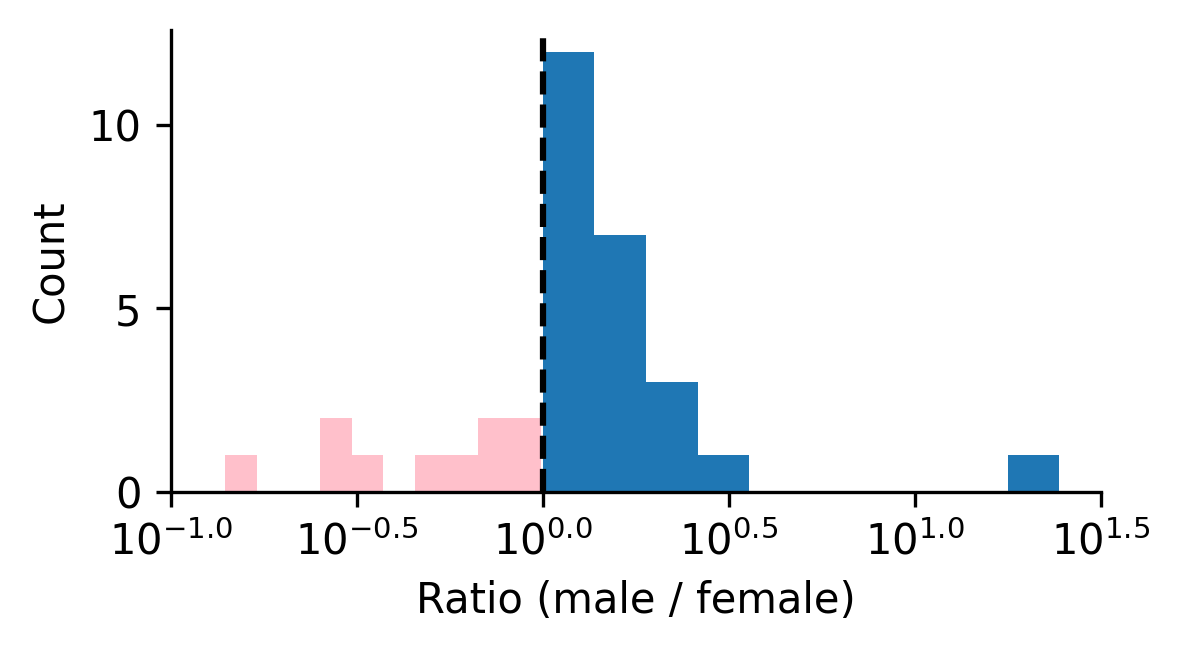

In [34]:
plt.figure(figsize=(4, 2), dpi=300)
r = ratios[~np.isinf(ratios)]
logr = np.log10(r)
print('mean', r.mean(), 'frac>0', (r > 1).sum(), '/', len(r))
plt.hist(logr[logr < 0], color='pink') #, bins=100)
plt.hist(logr[logr >= 0], color='C0') #, bins=100)
plt.axvline(0, color='black', ls='--')
ticks = plt.xticks()[0]
plt.xticks(ticks, [f'$10^{{{t}}}$' for t in ticks])
plt.xlabel('Ratio (male / female)')
plt.ylabel('Count')
plt.show()